<div align="center">

# Pythresh Advanced Methods

</div>
<br>

The last notebook showed a simple approach to unsupervised outlier detection thresholding by selecting an outlier detector and thresholding method and visually inspecting the results. Luckily, the 2D PCA for the musk dataset was easy to distinguish the outlier points and determine if the applied methods were a good fit. However, this is often not the case, and it would be better if we had more surefire ways of being sure that the outlier methods applied are the correct ones. Well there are!

- Using multiple outlier detection scores
- Using multiple thresholding methods
- Using the interpretable thresholder `MIXMOD`

# Let's get started!

To begin, we need to install pythresh to work with the notebook


In [ ]:
!pip install pythresh

We can now import a dataset to work with

In [1]:
import os
from scipy.io import loadmat
from pyod.utils.utility import standardizer

file = os.path.join('data', 'cardio.mat')
mat = loadmat(file)

X = mat['X'].astype(float)
y = mat['y'].ravel().astype(int)

X = standardizer(X)


Now lets take a quick look at the data.

There are 1655 inliers and 176 outliers with a contamination of 9.61%


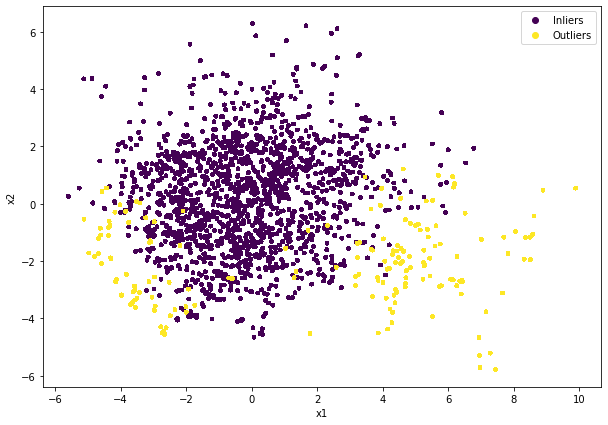

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

def plotter(X, y):

    fig = plt.figure(figsize=(10, 7))
    scatter = plt.scatter(X[:, 0], X[:, 1], c=y, s=8, antialiased=False)
    handles, _ = scatter.legend_elements()
    
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.legend(handles = handles, labels=['Inliers', 'Outliers'])
    plt.show()

# Lets see some stats
n = len(X)
inliers = len(y[y==0])
outliers = len(y[y==1])

print(f'There are {inliers} inliers and {outliers} outliers with a contamination of {round(outliers/n * 100, 2)}%') 

# To get a sense of the data lets decompose it into 2D
decomp = PCA(n_components=2)

X_decomp = decomp.fit_transform(X)

plotter(X_decomp, y)

<br>
Unlike with the musk dataset, the inlier and outlier classes are less distinguishable. 

Before we try the advanced options, for reference, lets fit a single an OD method and thresholder to see some baseline performance.


The f1 and mcc score of the outlier detection are 0.29 and 0.26 respectively


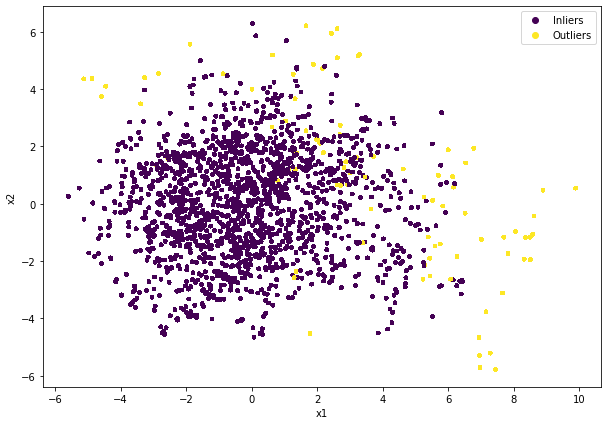

In [21]:
from pyod.models.loda import LODA
from pythresh.thresholds.iqr import IQR
from sklearn.metrics import f1_score, matthews_corrcoef

# Initialize and fit ODs and thresholder
clf = LODA()
clf.fit(X)

scores = clf.decision_scores_ 

thresh = IQR()
thresh.fit(scores)

fit_labels = thresh.labels_

# How did the unsupervised task perform, lets check the stats
metric1 = round(f1_score(y, fit_labels), 2)
metric2 = round(matthews_corrcoef(y, fit_labels), 2)

print(f'\nThe f1 and mcc score of the outlier detection are {metric1} and {metric2} respectively')

plotter(X_decomp, fit_labels)

<br>
While the performance was not dismal, maybe we can overcome it using our first advanced option. Multiple outlier detection methods.

<br>
<br>
How does it work? 

Well it takes the different outlier likelihood scores and decomposes them into a 1D combined decision score using `TruncatedSVD` which is then evaluated by the selected thresholder.


The f1 and mcc score of the outlier detection are 0.54 and 0.54 respectively


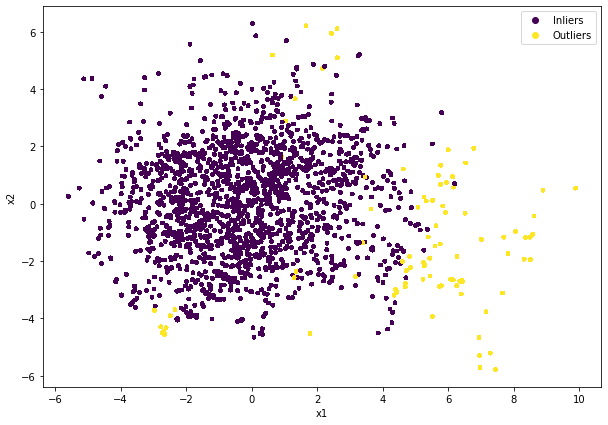

In [22]:
from pyod.models.pca import PCA as PCA_OD
from pythresh.thresholds.iqr import IQR
from sklearn.metrics import f1_score, matthews_corrcoef

# Initialize and fit ODs and thresholder
clfs = [PCA_OD(), LODA()]

# get outlier scores for each detector
scores = [clf.fit(X).decision_scores_ for clf in clfs]
scores = np.vstack(scores).T

thresh = IQR()
thresh.fit(scores)

fit_labels = thresh.labels_

# How did the unsupervised task perform, lets check the stats
metric1 = round(f1_score(y, fit_labels), 2)
metric2 = round(matthews_corrcoef(y, fit_labels), 2)

print(f'\nThe f1 and mcc score of the outlier detection are {metric1} and {metric2} respectively')

plotter(X_decomp, fit_labels)

<br>
For the second advanced option, instead of using multiple outlier detection methods, we can use multiple thresholders instead.

<br>
<br>
How does it work?

Each thersholder is fitted on the decision scores, and the resulting labels are used to train a stacked (default) classifier model. The fitted model is then used to repredict the labels giving back a combined label prediction.


The f1 and mcc score of the outlier detection are 0.54 and 0.51 respectively


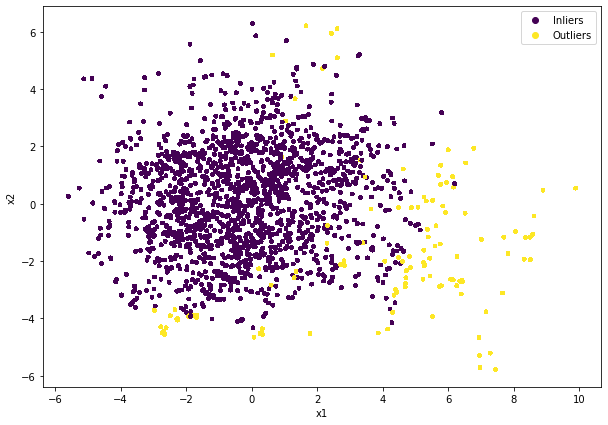

In [23]:
from pythresh.thresholds.comb import COMB
from pythresh.thresholds.dsn import DSN
from pythresh.thresholds.iqr import IQR
from pythresh.thresholds.karch import KARCH
from sklearn.metrics import f1_score, matthews_corrcoef

# Initialize and fit OD and thresholders
od = LODA()
od.fit(X)
scores = od.decision_scores_

thresholders = [DSN(), IQR(), KARCH()]

thresh = COMB(thresholders)
thresh.fit(scores)

fit_labels = thresh.labels_

# How did the unsupervised task perform, lets check the stats
metric1 = round(f1_score(y, fit_labels), 2)
metric2 = round(matthews_corrcoef(y, fit_labels), 2)

print(f'\nThe f1 and mcc score of the outlier detection are {metric1} and {metric2} respectively')

plotter(X_decomp, fit_labels)

<br>

Finally we have a model that might not necessarily perform better than the above mentioned models. But, instead can be used when interpretability is necessary and the simple thresholders like `IQR` and `ZSCORE` (which are easy to explain) are not looking too good.


The f1 and mcc score of the outlier detection are 0.61 and 0.57 respectively


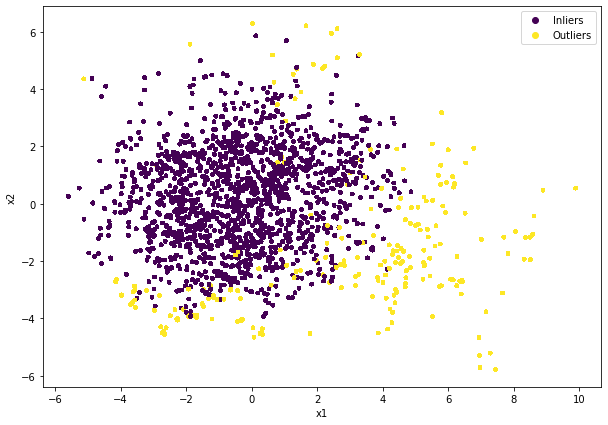

In [24]:
from pyod.models.loda import LODA
from pythresh.thresholds.mixmod import MIXMOD
from sklearn.metrics import f1_score, matthews_corrcoef

# Initialize and fit ODs and thresholder
od = LODA()
od.fit(X)
scores = od.decision_scores_

thresh = MIXMOD()
thresh.fit(scores)

fit_labels = thresh.labels_

# How did the unsupervised task perform, lets check the stats
metric1 = round(f1_score(y, fit_labels), 2)
metric2 = round(matthews_corrcoef(y, fit_labels), 2)

print(f'\nThe f1 and mcc score of the outlier detection are {metric1} and {metric2} respectively')

plotter(X_decomp, fit_labels)

Okay well that's not bad at all, but how do we interpret the selection for the threshold point?

Well, `MIXMOD` assumes that the outlier decision scores are composed of two distinct distributions, one for each class (inlier and outlier). It then fits all duo combinations (check the API for more) of the avaiable distributions using maximum likelihood estimation to best fit the duo to the decision scores. The threshold point is then calculated for each combo but getting the point where the posterior of the inlier and outlier distributions are equal. To determine the best duo distribution combo, all thresholds are compared to the mean (default) threshold and the closest is selected.

Whew, that was a lot of background. But, essentially all of these steps can be visualized. Therefore, we have a very interpretable result.

The first distribution used is fisk with params {'c': 26.55958713191281, 'scale': 1.1509238686406766}
The second distribution used is pareto with params {'scale': 1.0, 'b': 5.397102368807727}


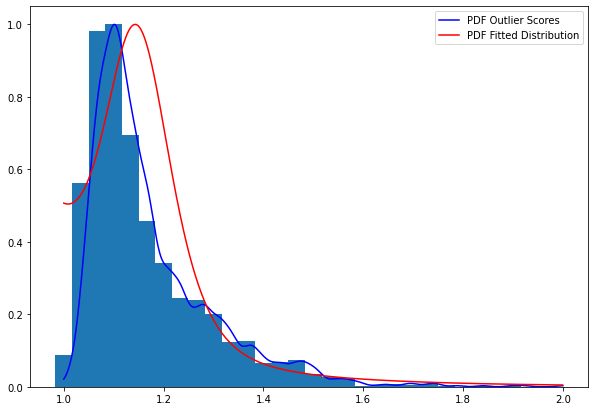

In [7]:
from pythresh.thresholds.thresh_utility import normalize
import scipy.stats as stats

dist1 = thresh.mixture_.components[0]
dist2 = thresh.mixture_.components[1]

dist1_params = thresh.mixture_.params[0]
dist2_params = thresh.mixture_.params[1]

print(f'The first distribution used is {dist1.name} with params {dist1_params}')
print(f'The second distribution used is {dist2.name} with params {dist2_params}')

# Lets look at the best fitted distribution
scores_norm = normalize(scores) + 1
x = np.linspace(1, 2, 1000)

dist = stats.gaussian_kde(scores_norm, bw_method=0.1)
kde = dist(x)

pdf = thresh.mixture_.pdf(x)

fig = plt.figure(figsize=(10, 7))
counts, bins = np.histogram(scores_norm, bins=30)
plt.bar(bins[:-1], counts / max(counts), width=np.diff(bins))
plt.plot(x, kde/kde.max(), 'b', label='PDF Outlier Scores')
plt.plot(x, pdf/pdf.max(), 'r', label='PDF Fitted Distribution')
plt.legend()
plt.show()

That's a good start but there is more. Let's take a look at each distribution from the fitted duo as well as their posteriors and selected threshold point

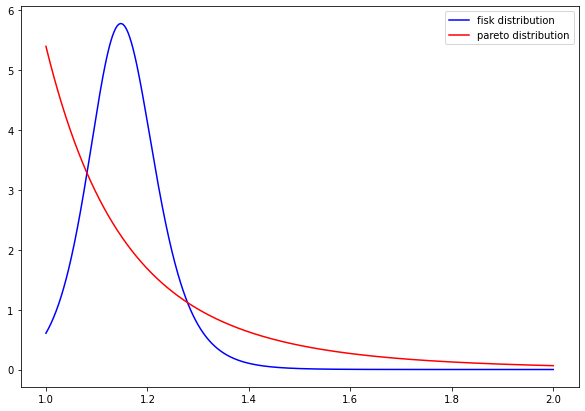

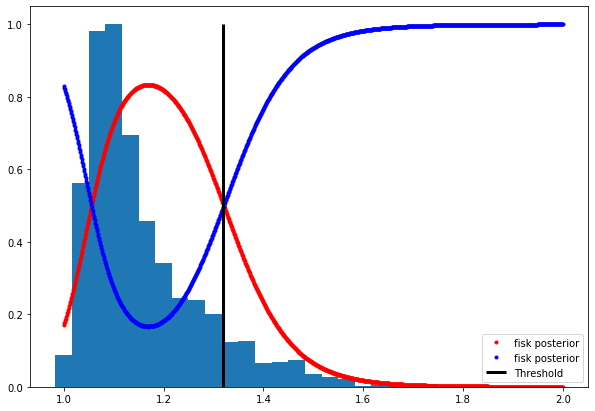

In [8]:
# Plot each distribution
d1 = dist1(**dist1_params)
sample1 = d1.pdf(x)

d2 = dist2(**dist2_params)
sample2 = d2.pdf(x)

fig = plt.figure(figsize=(10, 7))
plt.plot(x, sample1, 'b', label=f'{dist1.name} distribution')
plt.plot(x, sample2, 'r', label=f'{dist2.name} distribution')
plt.legend()
plt.show()

# Get the posterior probability threshold for equal posteriors
pos = thresh.mixture_.posterior(x)
crossing = thresh.thresh_ + 1

fig = plt.figure(figsize=(10, 7))
plt.bar(bins[:-1], counts / max(counts), width=np.diff(bins))
plt.plot(x, pos[0], 'r.', label=f'{dist1.name} posterior')
plt.plot(x, pos[1], 'b.', label=f'{dist1.name} posterior')
plt.vlines(crossing, 0, 1, 'k', linewidth=3, label='Threshold')
plt.legend()